<a href="https://colab.research.google.com/github/drsunithaev/Hate_Speech_Recognition/blob/main/Hate_Speech_Classification_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_path = "/content/drive/MyDrive/iNeuron/Hate Speech"

In [3]:
%cd "/content/drive/MyDrive/iNeuron/Hate Speech"

/content/drive/MyDrive/iNeuron/Hate Speech


In [4]:
%pwd

'/content/drive/MyDrive/iNeuron/Hate Speech'

### Import the necessary libraries

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


---
### Read the data

In [6]:
imbalance_data = pd.read_csv("data/imbalanced_data.csv")

In [7]:
imbalance_data.head(5)

id  label  \
0   1      0   
1   2      0   
2   3      0   
3   4      0   
4   5      0   

                                                                                                                        tweet  
0                       @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run  
1  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked  
2                                                                                                         bihday your majesty  
3                                      #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦    
4                                                                                      factsguide: society now    #motivation

---
### EDA

<Axes: xlabel='label', ylabel='count'>

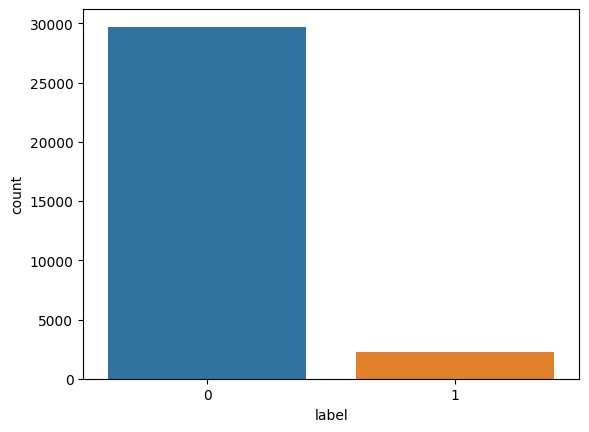

In [8]:
sns.countplot(x='label',data =imbalance_data)

From the above plot we can see that classes are imbalanced, we will fix it later.

In [9]:
# Checking the shape of the data
imbalance_data.shape

(31962, 3)

In [10]:
# Cheking if null values are present in the dataset or not.
imbalance_data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [11]:
# Let's drop the 'id' column as it is not required.
imbalance_data.drop('id',axis=1, inplace =True)

In [12]:
imbalance_data.head()

label  \
0      0   
1      0   
2      0   
3      0   
4      0   

                                                                                                                        tweet  
0                       @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run  
1  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked  
2                                                                                                         bihday your majesty  
3                                      #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦    
4                                                                                      factsguide: society now    #motivation

In [13]:
# Let's load another dataset similar to our dataset, since we want to fix the imbalance data.
raw_data = pd.read_csv("data/raw_data.csv")

In [15]:
raw_data.head()

Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                                                                                                                          tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...  
1                                                         !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!  
2                      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit  
3                                                                                !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny  
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;

In [16]:
raw_data.shape

(24783, 7)

In [17]:
raw_data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [14]:
# Let's drop the columns which are not required for us.
raw_data.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace =True)

In [15]:
raw_data.head()

class  \
0      2   
1      1   
2      1   
3      1   
4      1   

                                                                                                                                          tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...  
1                                                         !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!  
2                      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit  
3                                                                                !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny  
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;

In [16]:
# Let's check for the unique values in the dataset
raw_data['class'].unique()

array([2, 1, 0])

<Axes: xlabel='class', ylabel='count'>

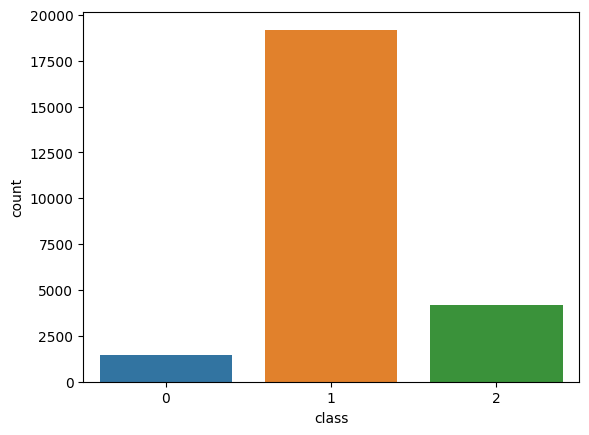

In [17]:
# Plotting the countplot for our new dataset
sns.countplot(x='class',data =raw_data)

- class 0: hate
- class 1: abusive
- class 2: no hate

Let's copy the valus of the class 1 into class 0.

In [18]:
raw_data[raw_data['class']==0]['class']=1

<ipython-input-18-55e395ab275c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[raw_data['class']==0]['class']=1


In [23]:
raw_data.head()

class  \
0      2   
1      1   
2      1   
3      1   
4      1   

                                                                                                                                          tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...  
1                                                         !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!  
2                      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit  
3                                                                                !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny  
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;

In [24]:
raw_data['class'].unique()

array([2, 1, 0])

In [ ]:
# Let's check the values in the class 0
raw_data[raw_data['class']==0]

In [20]:
# replace the value of 0 to 1
raw_data["class"].replace({0:1},inplace=True)

In [21]:
raw_data["class"].unique()

array([2, 1])

<Axes: xlabel='class', ylabel='count'>

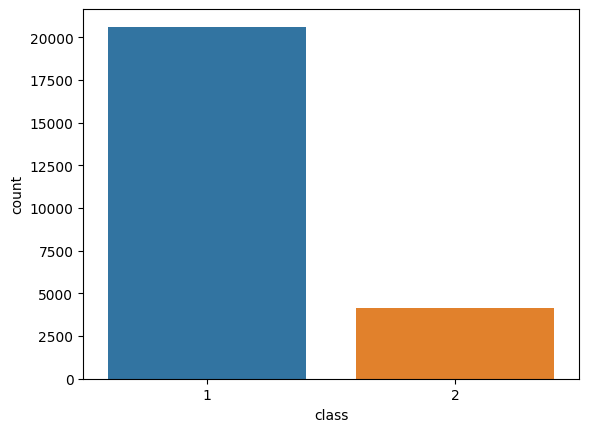

In [22]:
sns.countplot(x="class",data= raw_data)

In [23]:
# Let's replace the value of 2 to 0.
raw_data["class"].replace({2:0}, inplace = True)

<Axes: xlabel='class', ylabel='count'>

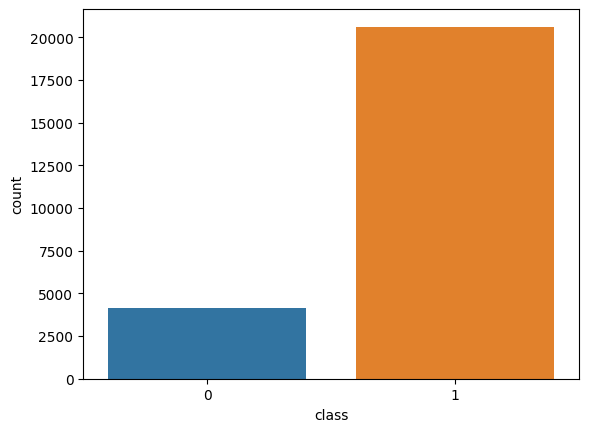

In [24]:
sns.countplot(x='class',data=raw_data)

In [25]:
# Let's change the name of the 'class' to label
raw_data.rename(columns={'class':'label'},inplace =True)

In [32]:
raw_data.head()

label  \
0      0   
1      1   
2      1   
3      1   
4      1   

                                                                                                                                          tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...  
1                                                         !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!  
2                      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit  
3                                                                                !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny  
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;

In [26]:
raw_data.iloc[0]['tweet']

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [27]:
# Let's concatinate both the data into a single data frame.
frame = [imbalance_data, raw_data]
df = pd.concat(frame)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56745 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   56745 non-null  int64 
 1   tweet   56745 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [65]:
df[df.label==1].tweet

13       user cnn calls michigan middle school build the wall chant  tcot   user cnn calls michigan middle school build the wall chant  tcot   user cnn calls michigan middle school build the wall chant  tcot   user cnn calls michigan middle school build the wa...
14       no comment  in australia   opkillingbay seashepherd helpcovedolphins thecove  helpcovedolphin no comment  in australia   opkillingbay seashepherd helpcovedolphins thecove  helpcovedolphin no comment  in australia   opkillingbay seashepherd helpcovedol...
17                                                                                                                                                        retweet if you agree  retweet if you agree  retweet if you agree  retweet if you agree  retweet if you agree 
23       user user lumpy says i am a  prove it lumpi user user lumpy says i am a  prove it lumpi user user lumpy says i am a  prove it lumpi user user lumpy says i am a  prove it lumpi user user lumpy says i 

In [63]:
df.head()

label  \
0      0   
1      0   
2      0   
3      0   
4      0   

                                                                                                                                                                                                                                                            tweet  
0   user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so self...  
1  user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthank user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthank user user thanks for lyft...  
2                                                                                                                                                     bihday your majesti   bihday your majesti   bihday your majesti   bihday your majesti   bihday your majesti  
3  model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   mo...  
4   factsguide society now    motiv  factsguide society now    motiv  factsguide society now    motiv  factsguide society now    motiv  factsguide society now    motiv  factsguide society now    motiv  factsguide society now    motiv  factsguide society ...

<Axes: xlabel='label', ylabel='count'>

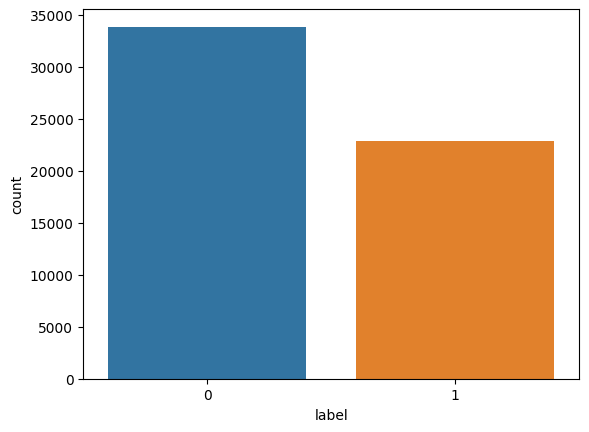

In [28]:
sns.countplot(x='label',data=df)

Now we can see that the problem of imbalace data has been solved.

In [29]:
df.shape

(56745, 2)

# Processing the text

In [30]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [31]:
# Let's apply regex and do cleaning.
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [32]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [33]:
df["tweet"][1]

1    user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthank user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthank user user thanks for lyft...
1     rt  boy dats coldtyga dwn bad for cuffin dat hoe in the  plac  rt  boy dats coldtyga dwn bad for cuffin dat hoe in the  plac  rt  boy dats coldtyga dwn bad for cuffin dat hoe in the  plac  rt  boy dats coldtyga dwn bad for cuffin dat hoe in the  plac...
Name: tweet, dtype: object

In [ ]:
# df.head(10)

In [34]:
x = df['tweet']
y = df['label']

In [35]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)

print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

42558 42558
14187 14187


In [36]:
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [37]:
len(x_test)

14187

In [38]:
max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [39]:
sequences_matrix

array([[    0,     0,     0, ...,   209, 13070,  4452],
       [    0,     0,     0, ...,   248,     3,   653],
       [    0,     0,     0, ...,     1,  1831, 41012],
       ...,
       [ 1126,   669,  2785, ...,   187,     1, 33462],
       [    0,     0,     0, ...,   954, 14416,   774],
       [    0,     0,     0, ...,   419,   378,    13]], dtype=int32)

In [40]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [41]:
# starting model training
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 1,validation_split=0.2)

266/266 [==============================] - 490s 2s/step - loss: 0.2727 - accuracy: 0.8987 - val_loss: 0.1737 - val_accuracy: 0.9381


In [42]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [43]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

444/444 [==============================] - 57s 129ms/step - loss: 0.1817 - accuracy: 0.9317


In [45]:
lstm_prediction = model.predict(test_sequences_matrix)

444/444 [==============================] - 54s 122ms/step


In [46]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)


In [47]:
print(confusion_matrix(y_test,res))

[[8143  310]
 [ 659 5075]]


In [48]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
# Let's save the mdoel.
model.save("model.h5")

In [50]:
import keras

In [51]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [67]:
# Let's test our model on custom data.
test = ' yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut y. '

def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

test=[clean_text(test)]
print(test)

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)

pred = load_model.predict(padded)

print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")


 yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut y. 
 yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut yeah im a bitch but guess what youre still a slut y 
[' yeah im bitch guess your still slut yeah im bitch guess your still slut yeah im bitch guess your still slut yeah im bitch guess your still slut yeah im bitch guess your still slut ']
[[296, 26, 13, 464, 25, 122, 707, 296, 26, 13, 464, 25, 122, 707, 296, 26, 13, 464, 25, 122, 707, 296, 26, 13, 464, 25, 122, 707, 296, 26, 13, 464, 25, 122, 707]]
1/1 [==============================] - 0s 79ms/step
pred [[0.98328173]]
hate and abusive


In [ ]:
df[df.label==1].tweet